In [ ]:
import os
from dotenv import load_dotenv
from pytube import YouTube
import whisper
from langchain_openai.chat_models import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.prompts import ChatPromptTemplate
import re
import tempfile
from langchain_core.runnables import RunnableParallel, RunnablePassthrough


In [ ]:

# Cargar variables de entorno
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

data_to_read = "data/transcription.txt"

## model = "gpt-4-0125-preview"
model_version = "gpt-4o-mini"


In [ ]:

with open(data_to_read) as file:
    transcription = file.read()


In [ ]:
# Paso 2: Trocear el texto manualmente
single_sentences_list = re.split(r'(?<=[.?!])\s+', transcription)

chunks = []
chunk_size = 10000
chunk = ""
for sentence in single_sentences_list:
    if len(chunk) + len(sentence) < chunk_size:
        chunk += " " + sentence
    else:
        chunks.append(chunk.strip())
        chunk = sentence
if chunk:
    chunks.append(chunk.strip())


In [ ]:
# Paso 3: Generar embeddings para los chunks
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

# Crear los documentos usando SemanticChunker (para el ejemplo)
from langchain_experimental.text_splitter import SemanticChunker
text_splitter = SemanticChunker(embeddings=embeddings)
docs = text_splitter.create_documents(chunks)


In [ ]:
docs[:10]

In [ ]:
# Paso 4: Cargar los embeddings en Pinecone
index_name = "youtube-rag-index-selfrag"

print("Removing data from pinecone")
PineconeVectorStore.get_pinecone_index(index_name).delete(delete_all=True)

print("Storing new data in pinecone")
pinecone = PineconeVectorStore.from_documents(
    docs, embedding=embeddings, index_name=index_name#, pinecone_api_key=PINECONE_API_KEY, pinecone_environment=PINECONE_ENV
)

import sys
import time

wait = 10
print(f'tasks done, now sleeping for {wait} seconds')
for i in range(wait,0,-1):
    sys.stdout.write(str(i)+' ')
    sys.stdout.flush()
    time.sleep(1)


In [ ]:
retriever = pinecone.as_retriever()

pinecone.similarity_search("Como se llama el entrevistado?")[:3]


### Definir el Graph

In [ ]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of an agent in the conversation.

    Attributes:
        keys: A dictionary where each key is a string and the value is expected to be a list or another structure
              that supports addition with `operator.add`. This could be used, for instance, to accumulate messages
              or other pieces of data throughout the graph.
    """

    keys: Dict[str, any]

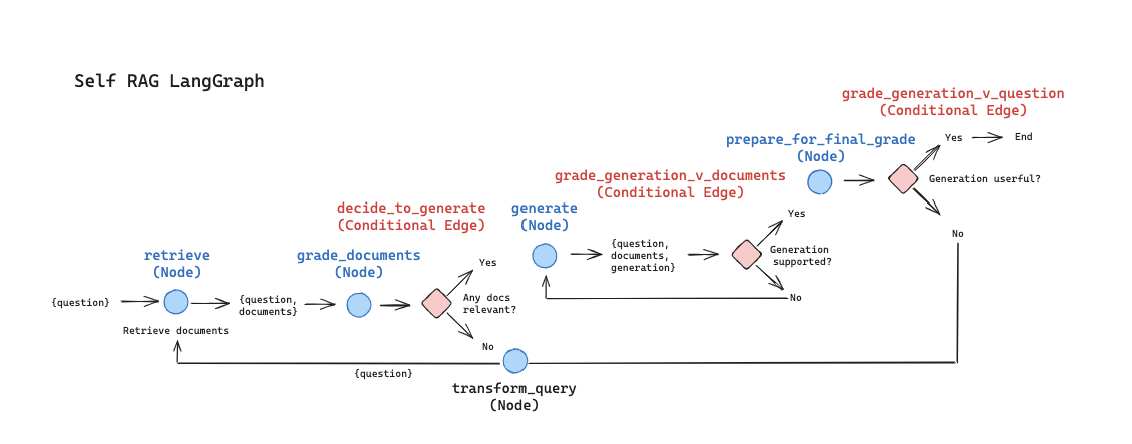

In [ ]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import ToolInvocation

### Nodes ###


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, documents, that contains documents.
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.invoke(question)
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, generation, that contains generation.
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model=model_version, temperature = temperature_grade)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, filtered_documents, that contains relevant documents.
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature = temperature_grade, model=model_version, streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    # Score
    filtered_docs = []
    for d in documents:
        score = chain.invoke({"question": question, "context": d.page_content})
        grade = score[0].binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    return {"keys": {"documents": filtered_docs, "question": question}}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New value saved to question.
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question: """,
        input_variables=["question"],
    )

    # Grader
    model = ChatOpenAI(temperature = temperature_grade, model=model_version, streaming=True)

    # Prompt
    chain = prompt | model | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {"keys": {"documents": documents, "question": better_question}}


def prepare_for_final_grade(state):
    """
    Stage for final grade, passthrough state.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        state (dict): The current state of the agent, including all keys.
    """

    print("---FINAL GRADE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


### Edges ###


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, filtered_documents, that contains relevant documents.
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents(state):
    """
    Determines whether the generation is grounded in the document.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision score.
    """

    print("---GRADE GENERATION vs DOCUMENTS---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Supported score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature = temperature_grade, model=model_version, streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
        Here are the facts:
        \n ------- \n
        {documents} 
        \n ------- \n
        Here is the answer: {generation}
        Give a binary score 'yes' or 'no' to indicate whether the answer is grounded in / supported by a set of facts.""",
        input_variables=["generation", "documents"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    score = chain.invoke({"generation": generation, "documents": documents})
    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: SUPPORTED, MOVE TO FINAL GRADE---")
        return "supported"
    else:
        print("---DECISION: NOT SUPPORTED, GENERATE AGAIN---")
        return "not supported"


def grade_generation_v_question(state):
    """
    Determines whether the generation addresses the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision score.
    """

    print("---GRADE GENERATION vs QUESTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Useful score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature = temperature_grade, model=model_version, streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
        Here is the answer:
        \n ------- \n
        {generation} 
        \n ------- \n
        Here is the question: {question}
        Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question.""",
        input_variables=["generation", "question"],
    )

    # Prompt
    chain = prompt | llm_with_tool | parser_tool

    score = chain.invoke({"generation": generation, "question": question})
    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: USEFUL---")
        return "useful"
    else:
        print("---DECISION: NOT USEFUL---")
        return "not useful"

### GRAPH

In [ ]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("prepare_for_final_grade", prepare_for_final_grade)  # passthrough

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents,
    {
        "supported": "prepare_for_final_grade",
        "not supported": "generate",
    },
)
workflow.add_conditional_edges(
    "prepare_for_final_grade",
    grade_generation_v_question,
    {
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [ ]:
question = """
    Cual es la tendencia actual de inversión en las criptomonedas?
    """

In [ ]:
# Run
inputs = {"keys": {"question": question}}

model_version = "gpt-4-0125-preview"
model_version = "gpt-4o"
model_version = "gpt-4o-mini"

temperature_grade = 0

for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")